## Importing required libraries

In [1]:
# Import depencies 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline   
import pickle
import requests

# Kaggle requirements
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

    
        
# ML Models
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

import warnings
warnings.filterwarnings("ignore")


/kaggle/input/edsa-movie-recommendation-predict/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-predict/movies.csv
/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-predict/train.csv
/kaggle/input/edsa-movie-recommendation-predict/test.csv
/kaggle/input/edsa-movie-recommendation-predict/tags.csv
/kaggle/input/edsa-movie-recommendation-predict/links.csv


## Loading data

In [17]:
# Loading movies data

df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/links.csv')
train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/train.csv')
test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/test.csv')


# Merge movielens and imdb datasets 
movies = pd.merge(df_movies, df_imdb, on='movieId')

In [3]:
movies.tail()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
24861,131254,Kein Bund für's Leben (2007),Comedy,Franz Dinda|Florian Lukas|Axel Stein|Kailas Ma...,Carsten Funke,85.0,NaN,man wrapped in a towel|man wears a thong|male ...
24862,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,Rick Kavanian|Axel Stein|Eva Habermann|Christo...,Matthias Dinter,83.0,"DEM5,800,000",ski|ski resort|ampersand in title|drink in title
24863,131258,The Pirates (2014),Adventure,Nam-gil Kim|Ye-jin Son|Hae-Jin Yoo|Kyeong-yeon...,Seong-il Cheon,130.0,NaN,pirate|sword fight|korea|bandit
24864,131260,Rentun Ruusu (2001),(no genres listed),Martti Suosalo|Ilkka Koivula|Vexi Salmi|Riitta...,Timo Koivusalo,102.0,NaN,friend|friendship|television show|restaurant
24865,131262,Innocence (2014),Adventure|Fantasy|Horror,Sophie Lane Curtis|Kelly Reilly|Graham Phillip...,Hilary Brougher,96.0,NaN,hex|witch|virgin|blood


In [4]:
movies.shape

(24866, 8)

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24866 entries, 0 to 24865
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        24866 non-null  int64  
 1   title          24866 non-null  object 
 2   genres         24866 non-null  object 
 3   title_cast     15201 non-null  object 
 4   director       15347 non-null  object 
 5   runtime        13521 non-null  float64
 6   budget         7283 non-null   object 
 7   plot_keywords  14384 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.7+ MB


In [6]:
#check for missing values
movies.isnull().sum()

movieId              0
title                0
genres               0
title_cast        9665
director          9519
runtime          11345
budget           17583
plot_keywords    10482
dtype: int64

In [7]:
#remove all movies with no genre listed
movies = movies[movies.genres != '(no genres listed)']

In [8]:
movies.shape

(24650, 8)

In [9]:
# replace nan with empty string
# using fillna() function
movies = movies.fillna('')

In [10]:
#check for missing values
movies.isnull().sum()

movieId          0
title            0
genres           0
title_cast       0
director         0
runtime          0
budget           0
plot_keywords    0
dtype: int64

In [11]:
# Merge the movies and links
movies = pd.merge(movies, df_links, on='movieId')

In [12]:
# check for duplicates
check_dups = movies.duplicated()
# display duplicates
print("Number of duplicate records:", sum(check_dups))

Number of duplicate records: 0


In [13]:
df = movies[['movieId','tmdbId','title','title_cast','director', 'plot_keywords','genres']]
df.head(2)

,movieId,tmdbId,title,title_cast,director,plot_keywords,genres
0,1,862.0,Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy
1,2,8844.0,Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24650 entries, 0 to 24649
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        24650 non-null  int64  
 1   tmdbId         24550 non-null  float64
 2   title          24650 non-null  object 
 3   title_cast     24650 non-null  object 
 4   director       24650 non-null  object 
 5   plot_keywords  24650 non-null  object 
 6   genres         24650 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB


In [15]:
# drop rows with missing tmdbId
df = df.dropna(subset=['tmdbId'])
df.isnull().sum()

movieId          0
tmdbId           0
title            0
title_cast       0
director         0
plot_keywords    0
genres           0
dtype: int64

In [16]:
df.shape

(24550, 7)

## Exploratory Data Analysis (EDA)

### Joining Datasets for analysis

In [13]:
# Merge the two movies datasets 
movies_df = pd.merge(df_movies, df_imdb, on='movieId', how ='left')

combined_df1 = pd.merge(movies,train , on='movieId')
# drop duplicates
combined_df1 = combined_df1.drop_duplicates('movieId')

In [14]:
combined_df1.shape

(23544, 11)

## Popular Movies by Genre

In [10]:
# Create an empty list
years = []
# Finding the number of movies published in each year
for title in movies_df['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
# Create a new column in a dataframe.       
movies_df['moviePubYear'] = years
print('The Number of Movies Published each year:',len(movies_df[movies_df['moviePubYear'] == 9999]))

The Number of Movies Published each year: 562


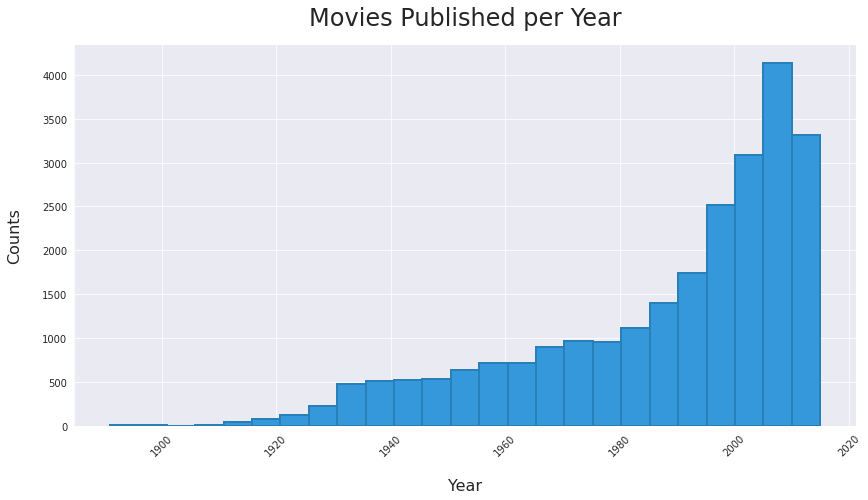

In [37]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', 
                   title='Title', xlab='X', ylab='Y', sort_index=False):
    """"
    This function gives a plot of the
    number of movies published per year
    
    Input : dataframe, dataframe column,
    bins, colour of figure, title of figure,
    x and y labels
    datatype : dataframe        
    
    output : Figure (bar plot)
    
    """
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.grid() 
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(movies, 'moviePubYear', title='Movies Published per Year', xlab='Year', ylab='Counts')

In [14]:
genre_df = pd.DataFrame(movies_df['genres'].str.split('|').tolist(), index=movies_df['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']

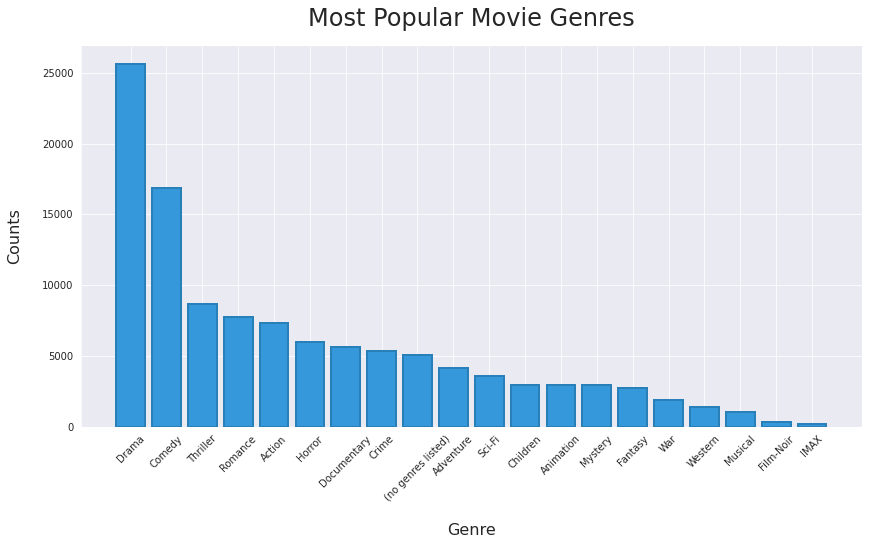

In [15]:
def make_bar_chart(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    
    """"
    This function gives the count of the
    different genres
    
    Input : dataframe, dataframe column,
    colour of figure, title of figure,
    x and y labels
    datatype : dataframe        
    
    output : Figure (bar plot)
    
    """
    
    if sort_index == False:
        xs = dataset[attribute].value_counts().index
        ys = dataset[attribute].value_counts().values
    else:
        xs = dataset[attribute].value_counts().sort_index().index
        ys = dataset[attribute].value_counts().sort_index().values
    
    # Plotting the figure   
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    # Plot the bar graph
    plt.grid() 
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
# Show the bar chart with selected features    
make_bar_chart(genre_df, 'Genre', title='Most Popular Movie Genres', xlab='Genre', ylab='Counts')

## Correlation Matrix

In [10]:
def plot_correlation_map( df ):
    
    """"
    This function gives a correlation map
    using all the features from merged data.
    
    Input : dataframe column
    datatype : dataframe (integer)        
    
    output : Figure (bar plot)
    
    """
    # Plotting using the features
    
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

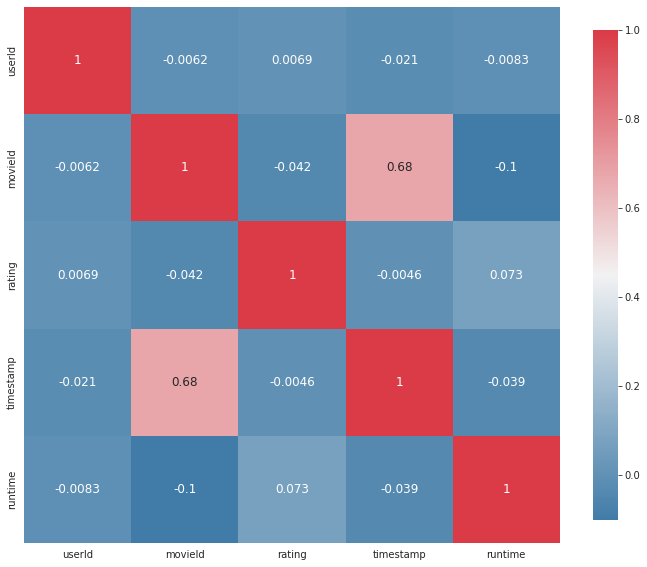

In [15]:
# Select a number of features from the dataframe to make the correlation map
plot_correlation_map(combined_df1[['userId','movieId','rating', 'timestamp', 'budget','runtime']])

#### Observations:

There is any significat positive correlations amongst the features , aside from timestamp and movieId.
There is a very clear correlation between movieId and timestamp, this is possibly because movies have different lengths and do not end at exactly the same time.

## Credits, Genres, and Keywords Based Recommender
The quality of your recommender would be increased with the usage of better metadata and by capturing more of the finer details. That is precisely what you are going to do in this section. I will building a recommender system based on the following metadata: the 3 top actors, the director, related genres, and the movie plot keywords.

## Converting movie attributes into one single feature 

In [ ]:
# Convert data types to strings
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

In [18]:
#we convert the title_cast column from list to string
df['liststring'] = df['title_cast'].apply(lambda x: ','.join(map(str, x)))

#we remove the commas between the string in each row
df['liststring'] = df['liststring'].replace(',',' ', regex=True)

In [19]:
#we choose keywords, cast(liststring), director and genres column to use as our features
df_features = df[['plot_keywords','liststring','director','genres']]

#we combine the features columns into  single string
df['combined_features'] = df_features['plot_keywords'] +' '+ df_features['liststring'] +' '+ df_features['director'] +' '+ df_features['genres']

In [20]:
# Remove unwanted  columns
df.drop(columns=['title_cast','director','plot_keywords','genres','liststring'], inplace=True)

In [21]:
#convert float for 'tmbId' to interger
df['tmdbId'] = df.tmdbId.astype(int)

#strip leading and trailing space from features column'''
df['combined_features'] = df['combined_features'].str.strip()

In [22]:
#drop movie_Id
df.drop('movieId', inplace=True, axis=1)

In [23]:
df.head(2)

,tmdbId,title,combined_features
0,862,Toy Story (1995),toy rivalry cowboy cgi animation tomhanks tima...
1,8844,Jumanji (1995),board game adventurer fight game robinwilliams...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24550 entries, 0 to 24649
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tmdbId             24550 non-null  int64 
 1   title              24550 non-null  object
 2   combined_features  24550 non-null  object
dtypes: int64(1), object(2)
memory usage: 767.2+ KB


In [ ]:
#export movies data for streamlit app
#df.to_csv('movies.csv', index=False)

In [26]:
#choose subset size for streamlit app
data = df.head(1000)

## **Convert the contents to vectors**

As our model will not be able to understand text inputs we would have to vectorize them and make it in form of machine readable format

In [37]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(data['combined_features'])

In [38]:
count_matrix.shape

(1000, 4607)

In [39]:
vectorized_dataframe = pd.DataFrame(count_matrix.toarray(), index=data['combined_features'].index.tolist())

## **Compute a similarity metric on vectors for recommendation**
Now in order to make recommendations we would have to compute any similarity index ex- cosine similarity, eucledian distance, Jaccard distance, etc. here we are going to use cosine similarity.

In [30]:
# Import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(vectorized_dataframe, vectorized_dataframe)

In [31]:
df.set_index('title', inplace = True)
indices = pd.Series(df.index)

In [32]:
indices[:10]

0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
5                           Heat (1995)
6                        Sabrina (1995)
7                   Tom and Huck (1995)
8                   Sudden Death (1995)
9                      GoldenEye (1995)
Name: title, dtype: object

## **Making recommendations for a given movie**

In [33]:
def recommendation(movie_title):
    id_of_movie = data[data['title']==movie_title].index[0]
    distances = cosine_sim[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:10]
    
    for i in movie_list:
        print(data.iloc[i[0]].title)

In [34]:
recommendation('Toy Story (1995)')

Wallace & Gromit: The Best of Aardman Animation (1996)
Oliver & Company (1988)
Aristocats, The (1970)
Pinocchio (1940)
Sword in the Stone, The (1963)
Snow White and the Seven Dwarfs (1937)
Cinderella (1950)
Escape to Witch Mountain (1975)
Winnie the Pooh and the Blustery Day (1968)


In [35]:
recommendation('Jumanji (1995)')

Escape to Witch Mountain (1975)
Wizard of Oz, The (1939)
Swiss Family Robinson (1960)
Super Mario Bros. (1993)
Alaska (1996)
Mortal Kombat (1995)
Pinocchio (1940)
Hungarian Fairy Tale, A (Hol volt, hol nem volt) (1987)
Mark of Zorro, The (1940)


## Collaborative Filtering
We will now focus on the **collaborative filtering** approach, that is: the user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

 #### Advantages:
 * No domain knowledge required
 * serendipity
 * Great starting point
 
 
 #### Disadvantages:
 * Cold start problem,fresh items/new users
 * Sparsity
 * No context features

## Loading Ratings data
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Project, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

All ratings are contained in the file `train.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format: `userId`,`movieId`,`rating`,`timestamp`


In [3]:
# import data
train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/train.csv')
test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/test.csv')

# Merge movies and ratings datasets to show titles 
combined_df = pd.merge(train, df_movies, on='movieId')

In [41]:
train.shape

(10000038, 4)

The ratings dataframe consists of 10'000'038 rows and 4 columns (userId, movieID, rating and timestamp).

In [4]:
#drop unwanted column
train.drop('timestamp', axis=1, inplace=True)
train.columns = ['userId', 'item', 'rating']

In [5]:
# show 5 rows of train dataset
train.head()

,userId,item,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [6]:
# check shape of data
train.shape

(10000038, 3)

In [45]:
# check datatype 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   item    int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 228.9 MB


In [5]:
# Checking for unique users and movieId's in the train dataset
users = len(train.userId.unique())
items = len(train.item.unique())
print('There are {} unique users and {}\
 unique movies train dataset with {} duplicated entries'.format(users, items, train[train.duplicated()].count().sum()))

There are 162541 unique users and 48213 unique movies train dataset with 0 duplicated entries


## Exploratory Data Analysis (EDA)

## Ratings Distribution

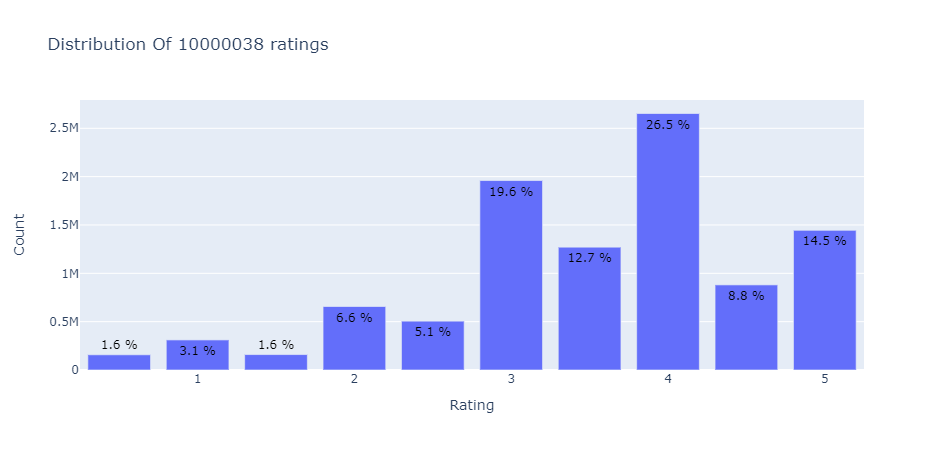

In [47]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = train['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / train.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(train.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

Ratings are from 0.5 to 5 in increments of 0.5. The majority of ratings were a 4, comprising of close to 27% of all the given data.

## Ratings Distribution By Movie


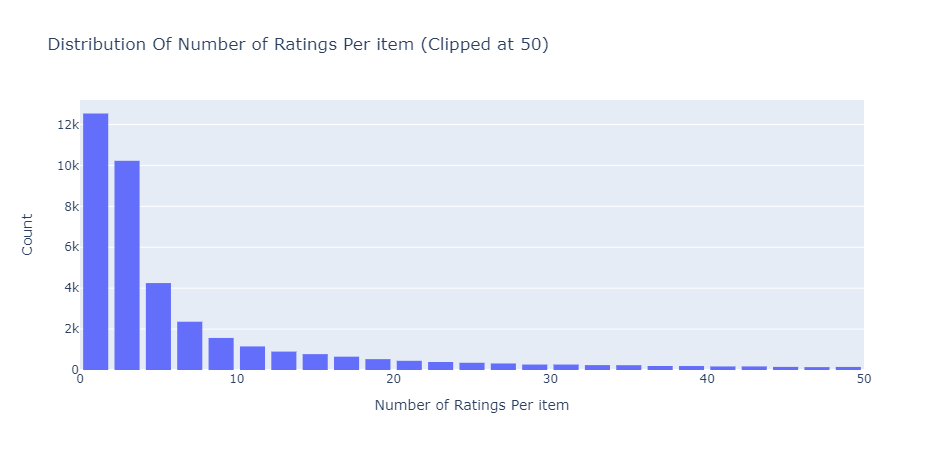

In [48]:
# Number of ratings per item
data = train.groupby('item')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [49]:
# Find top 10 highest rated movies
combined_df.groupby("title")["rating"].count().sort_values(ascending=False)[:10]

title
Shawshank Redemption, The (1994)             32831
Forrest Gump (1994)                          32383
Pulp Fiction (1994)                          31697
Silence of the Lambs, The (1991)             29444
Matrix, The (1999)                           29014
Star Wars: Episode IV - A New Hope (1977)    27560
Jurassic Park (1993)                         25518
Schindler's List (1993)                      24004
Braveheart (1995)                            23722
Fight Club (1999)                            23536
Name: rating, dtype: int64

## Ratings Distribution By User

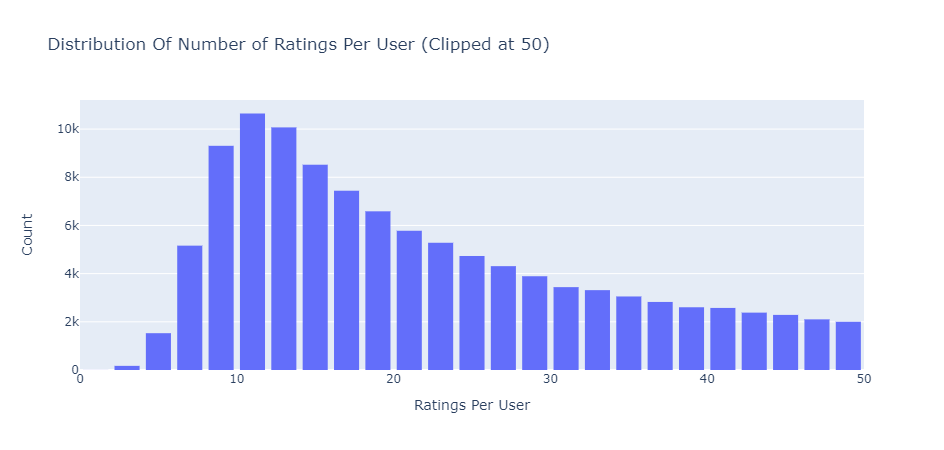

In [50]:
# Number of ratings per user
data = train.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [51]:
# top 10 users with  high number of ratings
train.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


## Python Library Imports
Importing the python packages that we'll use.

In [7]:
!pip install scikit-surprise
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.9/449.9 kB 8.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.2/498.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=7591e2c0d5827865a674cafc617666fb4f063d50dc0e726c76a095484539dd01
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [8]:
#import comet experiment
from comet_ml import Experiment
#comet_ml api Key
api_key = "Wg4tgIhuwsRj6kHdY3CCK6rmD"

## Setting up Algorithms for Model Training
To load a dataset from the pandas dataframe, we will use the `load_from_df()` method. We will also use a `Reader` object with the `rating_scale` parameter specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

### Dimensionality Reduction

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

In [9]:
min_ratings = 5
filter_items = train['item'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = train['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = train[(train['item'].isin(filter_items)) & (train['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(10000038, 3)
The new data frame shape:	(9936892, 3)


## Splitting of Training and Validation Sets
To load a dataset from the pandas dataframe, we will use the `load_from_df()` method. We will also use a `Reader` object with the `rating_scale` parameter specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [10]:
# Define sample size of 100 000 taken from train dataset
#train_sample = train.sample(n = 100000, replace = False)

# Define the Reader object by specifying the rating scale in the dataset
reader = Reader(rating_scale=(0.5, 5))

# Load the dataset from the pandas dataframe
data = Dataset.load_from_df(df_new[['userId', 'item', 'rating']], reader)

# Splitting dataset into train and validation sets
train_set, val_set = train_test_split(data, test_size=0.15, random_state=42)

### Surprise Library 

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Surprise was designed with the following purposes in mind:

* Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
* Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
* Make it easy to implement new algorithm ideas.
* Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.

Please note that surprise does not support implicit ratings or content-based information.

## Base Model Testing
With the Surprise library, we  going to perform base model testing on five algorithms: `SVD`, `NormalPredictor`, `BaseLineOnly`, `SlopeOne` and `CoClustering`.
We use RMSE as our accuracy metric for the predictions.

## Baseline Only
The `BaselineOnly` algorithm predicts the baseline estimate for a given user. This is based on the average rating from the entire ratings from the database and it is calculated as:
$r^ui=bui=μ+bu+bi$ 
If user  $u$  is unknown, then the bias  $bu$  is assumed to be zero. The same applies for item  $i$  with $bi$ .

In [62]:
#baselineOnly Model
BaselineOnly_1 = BaselineOnly()

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

# Train the algorithm on the train set, and predict ratings for the test set
BaselineOnly_1.fit(train_set)
pred_Baseline = BaselineOnly_1.test(val_set)

# Dictionary for the data to log for BLO model
params = {'model_name': 'BaseLineOnly'}
metrics = {'RMSE': accuracy.rmse(pred_Baseline, verbose=True)}

# Log the parameters and results for the BLO model
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End the experiment for the BLO experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/0ad01a9dc0a842ffb05a2cc2d3786ae9



Estimating biases using als...


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/0ad01a9dc0a842ffb05a2cc2d3786ae9
COMET INFO:   Metrics:
COMET INFO:     RMSE : 0.865520398849048
COMET INFO:   Parameters:
COMET INFO:     model_name : BaseLineOnly
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functiona

RMSE: 0.8655


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received


## Singular Value Decomposition (SVD)
`SVD` is a matrix decomposition method for reducing the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N). In the context of this project, the SVD is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

The prediction  $r^ui$  is set as:  $r^ui=μ+bu+bi+qTipu$ 
If user  $u$  is unknown, then the bias  bu  and the factors  pu  are assumed to be zero. The same applies for item  $i$  with  $bi$  and  $qi$ .

To estimate all the unknown, we minimize the following regularized squared error:
$∑rui∈Rtrain(rui−r^ui)2+λ(b2i+b2u+∥qi∥2+∥pu∥2)$
 
The minimization is performed by a very straightforward stochastic gradient descent:
$bu←bu+γ(eui−λbu)$
 
$bi←bi+γ(eui−λbi)$
 
$pu←pu+γ(eui.qi−λpu)$
 
$qi←qi+γ(eui.pu−λqi)$
 
where  $eui=rui−r^ui$ . These steps are performed over all the ratings of the trainset and repeated n_epochs times. Baselines are initialized to 0. User and item factors are randomly initialized according to a normal distribution, which can be tuned using the init_mean and init_std_dev parameters.


In [63]:
#SVD Model
SVD_1 = SVD()

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_1.fit(train_set)
pred_SVD_1 = SVD_1.test(val_set)

# Then compute RMSE
accuracy.rmse(pred_SVD_1)

# Dictionary for the data to log for BLO model
params = {'model_name': 'SVD'}
metrics = {'RMSE': accuracy.rmse(pred_SVD_1, verbose=True)}

# Log the parameters and results for the SVD model
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End the experiment for the SVD experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/b9132f9963764fbebeaa1b5469880bda



RMSE: 0.8288


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/b9132f9963764fbebeaa1b5469880bda
COMET INFO:   Metrics:
COMET INFO:     RMSE : 0.8288043308221299
COMET INFO:   Parameters:
COMET INFO:     model_name : SVD
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as 

RMSE: 0.8288


COMET INFO: Uploading 1 metrics, params and output messages


## KNN Basic

This is an algorithms that is directly derived from a basic nearest neighbors approach. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.

The actual number of neighbors that are aggregated to compute an estimation is necessarily less than or equal to  k . First, there might just not exist enough neighbors and second, the sets  $Nki(u)$  and $Nku(i)$ only include neighbors for which the similarity measure is positive. It would make no sense to aggregate ratings from users (or items) that are negatively correlated. For a given prediction, the actual number of neighbors can be retrieved in the `actual_k` field of the details dictionary of the prediction. 

In [64]:
# KNN Basic Model
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

collabKNN = KNNBasic(k=40, sim_options=sim_options)

rmseKNN = []
rmseSlope = []

collabKNN.fit(train_set)
predictionsKNN = collabKNN.test(val_set)
# get root means squared error
rmseKNN.append(accuracy.rmse(predictionsKNN, verbose=True))

# Dictionary for the data to log for KNN basic model
params = {'model_name': 'KNN Basic'}
metrics = {'RMSE': accuracy.rmse(predictionsKNN, verbose=True)}

# Log the parameters and results for the KNN basic model
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End the experiment for the KNN basic experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/eea03e53bb764ba99319b23d8cc35d33



Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9359


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/eea03e53bb764ba99319b23d8cc35d33
COMET INFO:   Metrics:
COMET INFO:     RMSE : 0.9359053333251094
COMET INFO:   Parameters:
COMET INFO:     model_name : KNN Basic
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionali

RMSE: 0.9359


COMET INFO: Uploading 1 metrics, params and output messages


## KNNWithMeans
The `KNNWithMeans` is also a basic nearest-neighbor based collaborative filtering algorithm which takes mean rating of each user into account.

In [65]:
# Modeling
KNNMeans = KNNWithMeans(sim_options=sim_options)
rmseKNNMeans = []

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

KNNMeans.fit(train_set)
KNNMeansPreds = KNNMeans.test(val_set)
# Get root means squared error
rmseKNNMeans.append(accuracy.rmse(KNNMeansPreds, verbose=True))

# Dictionary for the data to log for KNN basic model
params = {'model_name': 'KNNWithMeans'}
metrics = {'RMSE': accuracy.rmse(KNNMeansPreds, verbose=True)}

# Log the parameters and results for the KNN basic model
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End the experiment for the KNN basic experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/4d694e6588204773b4aaee7f79ca953b



Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8567


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/4d694e6588204773b4aaee7f79ca953b
COMET INFO:   Metrics:
COMET INFO:     RMSE : 0.8566632276231031
COMET INFO:   Parameters:
COMET INFO:     model_name : KNNWithMeans
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging function

RMSE: 0.8567


COMET INFO: Uploading 1 metrics, params and output messages


## KNNWithZscore
The `KNNWithZScore` is also a basic nearest-neighbor based collaborative filtering algorithm which takes the z-score normalization of each user into account.

In [ ]:
# Modeling
KNNZsco = KNNWithZScore(sim_options=sim_options)
rmseKNNZscore = []

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

KNNZsco.fit(train_set)
KNNZscorePreds = KNNZsco.test(val_set)
# Get root means squared error
rmseKNNZscore.append(accuracy.rmse(KNNZscorePreds, verbose=True))

# Dictionary for the data to log for KNN basic model
params = {'model_name': 'KNNWithZscore'}
metrics = {'RMSE': accuracy.rmse(KNNZscorePreds, verbose=True)}

# Log the parameters and results for the KNN basic model
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End the experiment for the KNN basic experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/7707281805f14cfba2da5221a456b0c7



## CoClustering 
Basically, users and items are assigned some clusters  $Cu$,$Ci$ , and some co-clusters  Cui . The prediction  $r^ui$  is set as:
$r^ui=Cui¯+(μu−Cu¯)+(μi−Ci¯)$
 
where  $Cui¯$  is the average rating of co-cluster  $Cui$ ,  $Cu$  is the average rating of  $u$ $’s$ cluster, and  $Ci¯$  is the average rating of  $i$ $’s$ cluster.

If the user is unknown, the prediction is  $r^ui=μi$ . If the item is unknown, the prediction is  $r^ui=μu$ . If both the user and the item are unknown, the prediction is  $r^ui=μ$ .

In [11]:
# Modeling
coClus = CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25)
rmseCo = []

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

coClus.fit(train_set)
predictionsCoClus = coClus.test(val_set)
# get root means squared error
rmseCo.append(accuracy.rmse(predictionsCoClus, verbose=True))

# Dictionary for the data to log for CoClustering model
params = {'model_name': 'CoClustering'}
metrics = {'RMSE': accuracy.rmse(predictionsCoClus, verbose=True)}

# Log the parameters and results for the CoClustering model
experiment.log_parameters(params)
experiment.log_parameters(metrics)

# End the experiment for the CoClustering experiment
experiment.end

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/2dfa8cf1087e47b1abfbaa1e7e824d80



RMSE: 0.8920
RMSE: 0.8920


<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x7f8c9c082d50>>

## KNNBaseline
The `KNNBaseline` is also a basic nearest-neighbor based collaborative filtering algorithm which takes mean rating of each user into account.

In [ ]:
# Modeling
KNNBaseL = KNNBaseline(sim_options=sim_options)
rmseKNNBaseL = []

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")


KNNBaseL.fit(train_set)
KNNBaseLPreds = KNNBaseL.test(val_set)
# Get root means squared error
rmseKNNBaseL.append(accuracy.rmse(KNNBaseLPreds, verbose=True))

# Dictionary for the data to log for KNNBaseLine model
params = {'model_name': 'KNNBaseLine'}
metrics = {'RMSE': accuracy.rmse(KNNBaseLPreds, verbose=True)}

# Log the parameters and results for the KNNBaseLine model
experiment.log_parameters(params)
experiment.log_parameters(metrics)
# End the experiment for the KNNBaseLine experiment
experiment.end()

## Non-negative Matrix Factorization (NMF)
This is a non-negative matrix approximation where a matrix is factorized into (usually) two matrices, with the property that all three matrices have no negative elements.

Suppose we factorize a matrix  $X$  into two matrices  $W$  and  $H$  so that  $X$   $≈$   $WH$ . There is no guarantee that we can recover the original matrix, so we will approximate it as best as we can. Now, suppose that  $X$  is composed of m rows  $x1$ ,  $x2$ , ...  $xm$  ,  $W$  is composed of k rows  $w1$ ,  $w2$ , ...  $wk$ ,  $H$  is composed of m rows  $h1$ ,  $h2$ , ...  hm  . Each row in  $X$  can be considered a data point. For instance, in the case of decomposing images, each row in  $X$  is a single image, and each column represents some feature.



In [12]:
# Modelling
NMF = NMF()
rmseNMF = []

# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

NMF.fit(train_set)
NMFPreds = NMF.test(val_set)
rmseNMF.append(accuracy.rmse(NMFPreds,verbose=True))#get root means squared error

    
# Dictionary for the data to log for the NMF model
params = {'model_name': 'NMF'}
metrics = {'RMSE': accuracy.rmse(NMFPreds,verbose=True)}

# Log the parameters and results for the NMF model
experiment.log_parameters(params)
experiment.log_parameters(metrics)
# End the experiment for the NMF experiment
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/2dfa8cf1087e47b1abfbaa1e7e824d80
COMET INFO:   Parameters:
COMET INFO:     RMSE       : 0.8920082976973978
COMET INFO:     model_name : CoClustering
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebo

RMSE: 0.8789


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/recommender-system/c3728138eadf443fab38ed3097e3d68f
COMET INFO:   Parameters:
COMET INFO:     RMSE       : 0.8789222341522916
COMET INFO:     model_name : NMF
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been impor

RMSE: 0.8789


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


## Dimensionality Reduction
To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users and define sample size.

In [ ]:
# filter out rarely rated movies and rarely rating users
min_ratings = 5
filter_items = train['movieId'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = train['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
df_new = train[(train['movieId'].isin(filter_items)) & (train['userId'].isin(filter_users))]

# Define sample size of 500 000 taken from train dataset
# The samples are taken without replacement
train_sample = df_new.sample(n = 500000, replace = False)

## Hyperparameter Tuning of Best Model
Applying Hyperparameter tuning to our SVD Model to improve performance.

In [11]:
# Setting the API key (saved as environment variable)
experiment = Experiment(api_key,
                        project_name="recommender-system", workspace="ml-projects")

rating_scale = Reader(rating_scale=(0.5, 5))
train_df = Dataset.load_from_df(df_new[['userId', 'item', 'rating']], rating_scale)

# Training and validation set split for hypertuning
train_set, val_set = train_test_split(train_df,
                                      test_size=0.008,
                                      random_state=42)

# Modelling of the SVD hypertuning
svd_algo_hyper = SVD(n_factors=160, 
                     lr_all=0.0085,
                     reg_all=0.02,
                     n_epochs=20,
                     init_std_dev=0.01)
svd_algo_hyper.fit(train_set)

# Predicting on the validation set
svd_hyper_predictions = svd_algo_hyper.test(val_set)

# Convert the predictions to dataframe
#test = pd.DataFrame(predictions)
accuracy.rmse(svd_hyper_predictions)

# Dictionary for the data to log 
params = {'model_name': 'SVD_Tuned'}
metrics = {'RMSE': accuracy.rmse(svd_hyper_predictions,verbose=True)}

# Log the parameters and results
experiment.log_parameters(params)
experiment.log_parameters(metrics)
# End the experiment 
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ml-projects/recommender-system/9ffb27ccc64f45bdbd0963172a6cc9c2

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ml-projects/rec

RMSE: 0.7889
RMSE: 0.7889


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


Predicting on the test set with the hypertuned SVD

In [ ]:
pred_svd_hyper = [svd_algo_hyper.predict(row.userId,
                                         row.movieId) for idx,row in test.iterrows()]

# Converting the predictions to a dataframe
test_pred_svd_hyper = pd.DataFrame(pred_svd_hyper)

In [ ]:
#renaming the fields of the prediction dataframe
test_pred_svd_hyper.drop(['r_ui', 'details'], axis=1, inplace=True)
test_pred_svd_hyper = test_pred_svd_hyper.rename(columns={'uid':'userId',
                                                          'iid':'movieId',
                                                          'est':'rating'})
test_pred_svd_hyper.head()

In [ ]:
# Concatenating each userId and movieId to a single Id column for submission
test_pred_svd_hyper['Id'] =  test_pred_svd_hyper['userId'].astype(str).str.zfill(1) + '_' + test_pred_svd_hyper['movieId'].astype(str).str.zfill(1)

In [ ]:
svd_hyper_predictions = test_pred_svd_hyper[['Id','rating']]
svd_hyper_predictions.tail()

In [ ]:
# kaggle final submission file
svd_hyper_predictions.to_csv("submission.csv", index=False)

In [ ]:
# Dumping model to file
import pickle, gzip, pickletools
with gzip.open("svd_model.pkl", "wb") as f:
    pickled = pickle.dumps(svd_algo_hyper)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)